In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 4)

In [ ]:
df = pd.read_csv('identity_metrics.csv')
df['month'] = pd.to_datetime(df['month'])

In [ ]:
# Define percentile-based thresholds for high update pressure
demo_warning_threshold = df['demo_update_ratio'].quantile(0.90)
bio_warning_threshold = df['bio_update_ratio'].quantile(0.90)

In [ ]:
# Create binary warning flags based on update pressure thresholds
df['demo_update_warning'] = df['demo_update_ratio'] > demo_warning_threshold
df['bio_update_warning'] = df['bio_update_ratio'] > bio_warning_threshold

In [ ]:
# Create a composite identity stress indicator
df['identity_stress_flag'] = (
    df['demo_update_warning'] |
    df['bio_update_warning']
)

## Visual 1: National Aadhaar Update Pressure Over Time

This chart establishes a national baseline by tracking how average demographic and biometric update ratios evolve month-on-month.

It helps assess whether Aadhaar system stress is episodic or structurally increasing.

In [ ]:
national_stress_trend = (
    df
    .groupby('month', as_index=False)
    .agg({
        'demo_update_ratio': 'mean',
        'bio_update_ratio': 'mean',
        'identity_stress_flag': 'mean'  \
    })
)

national_stress_trend

,month,demo_update_ratio,bio_update_ratio,identity_stress_flag
0,2025-03-01,181.138371,121.009800,0.808219
1,2025-04-01,7.070445,34.907959,0.364662
2,2025-05-01,4.921201,34.616427,0.365979
3,2025-06-01,3.605920,25.252833,0.310502
4,2025-07-01,2.394626,15.231016,0.187879
5,2025-09-01,5.804659,4.873074,0.018981
6,2025-10-01,7.106803,6.619541,0.057460
7,2025-11-01,10.217278,7.922605,0.096386
8,2025-12-01,17.248632,13.256779,0.286579


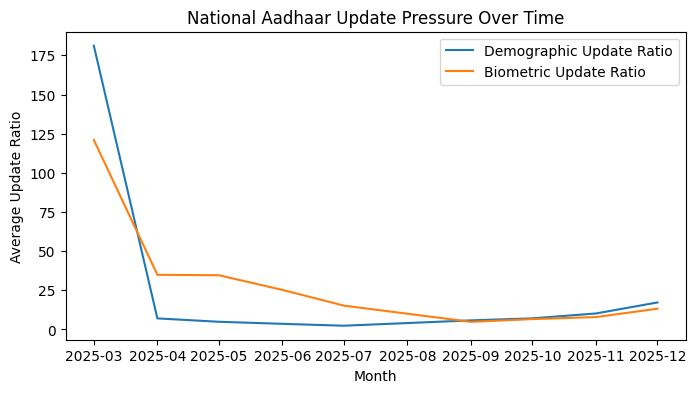

In [ ]:
national_stress_trend = (
    df
    .groupby('month', as_index=False)
    .agg({
        'demo_update_ratio': 'mean',
        'bio_update_ratio': 'mean'
    })
)

plt.plot(national_stress_trend['month'], national_stress_trend['demo_update_ratio'], label='Demographic Update Ratio')
plt.plot(national_stress_trend['month'], national_stress_trend['bio_update_ratio'], label='Biometric Update Ratio')
plt.title('National Aadhaar Update Pressure Over Time')
plt.xlabel('Month')
plt.ylabel('Average Update Ratio')
plt.legend()
plt.show()

In [ ]:
national_stress_trend['demo_ratio_trend'] = (
    national_stress_trend['demo_update_ratio']
    .rolling(window=3, min_periods=1)
    .mean()
)

national_stress_trend['bio_ratio_trend'] = (
    national_stress_trend['bio_update_ratio']
    .rolling(window=3, min_periods=1)
    .mean()
)

In [ ]:
national_stress_trend['demo_trend_direction'] = (
    national_stress_trend['demo_ratio_trend'].diff()
)

national_stress_trend['bio_trend_direction'] = (
    national_stress_trend['bio_ratio_trend'].diff()
)

In [ ]:
national_stress_trend[
    ['month', 'demo_trend_direction', 'bio_trend_direction']
]

,month,demo_trend_direction,bio_trend_direction
0,2025-03-01,NaN,NaN
1,2025-04-01,-87.033963,-43.050921
2,2025-05-01,-29.727736,-14.447484
3,2025-06-01,-59.177484,-31.918989
4,2025-07-01,-1.558606,-6.558981
5,2025-09-01,0.294486,-9.914451
6,2025-10-01,1.166961,-6.211097
7,2025-11-01,2.607550,-2.436137
8,2025-12-01,3.814658,2.794568


## Visual 2: State-Level Deviation from National Aadhaar Stress

This visual compares state-level update ratios against the national average, highlighting states that consistently experience higher update pressure and may require targeted administrative attention.

### Administrative Unit Standardisation
State name canonicalisation is applied at this stage to ensure accurate governance-level aggregation during visual analysis.


In [ ]:
# Step 1: Normalize raw state text
df['state_clean'] = (
    df['state']
    .str.lower()
    .str.replace('&', 'and')
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

# Step 2: Canonical mapping (ALL lower-case keys)
state_mapping = {
    'westbengal': 'west bengal',
    'west bengal': 'west bengal',
    'daman and diu': 'dadra and nagar haveli and daman and diu',
    'dadra and nagar haveli': 'dadra and nagar haveli and daman and diu',
    'dadra and nagar haveli and daman and diu': 'dadra and nagar haveli and daman and diu',
    'the dadra and nagar haveli and daman and diu': 'dadra and nagar haveli and daman and diu'
}

df['state_clean'] = df['state_clean'].replace(state_mapping)

In [ ]:
# Step 3: Apply consistent title casing AFTER all mapping
df['state_clean'] = df['state_clean'].str.title()

### Data Quality Validation (Sanity Check)
The following check ensures that administrative unit names are consistently standardised before aggregation.
This step is used for internal validation and is not part of the analytical results presented in the report.


In [ ]:
df['state_clean'].value_counts()[
    df['state_clean'].value_counts().index
        .str.contains('Dadra|Daman', case=False)
]

,count
state_clean,
Dadra And Nagar Haveli And Daman And Diu,37
Andaman And Nicobar Islands,21


In [ ]:
df['state_clean'].nunique(), df['state'].nunique()

(40, 55)

In [ ]:
state_trend = (
    df
    .groupby(['month', 'state_clean'], as_index=False)
    .agg({
        'demo_update_ratio': 'mean',
        'bio_update_ratio': 'mean'
    })
)

state_trend = state_trend.sort_values(['state_clean', 'month'])

state_trend['demo_trend'] = (
    state_trend.groupby('state_clean')['demo_update_ratio']
    .diff()
)

state_trend['bio_trend'] = (
    state_trend.groupby('state_clean')['bio_update_ratio']
    .diff()
)

In [ ]:
state_trend.sort_values('demo_trend', ascending=False).head(10)

,month,state_clean,demo_update_ratio,bio_update_ratio,demo_trend,bio_trend
273,2025-12-01,Rajasthan,50.344170,9.903895,38.894331,4.894277
240,2025-11-01,West Bangal,38.000000,7.000000,31.250000,3.500000
38,2025-04-01,Tamil Nadu,25.867803,207.499708,25.867803,207.499708
274,2025-12-01,Sikkim,33.794859,13.584210,23.074058,10.126483
223,2025-11-01,Maharashtra,35.915716,21.965247,18.638437,4.085992
224,2025-11-01,Manipur,44.830315,16.521917,18.294249,4.158202
184,2025-10-01,Manipur,26.536066,12.363715,17.853293,5.972622
252,2025-12-01,Goa,28.290842,23.914103,16.616709,13.549294
267,2025-12-01,Nagaland,22.928088,25.508526,16.580667,17.418512
249,2025-12-01,Chhattisgarh,27.569302,25.771920,14.852596,14.929950


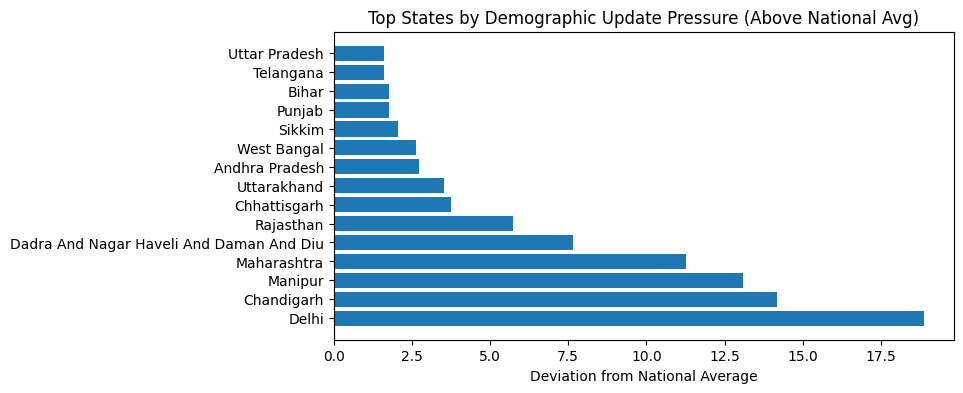

In [ ]:
state_avg = (
    df
    .groupby('state_clean', as_index=False)
    .agg({
        'demo_update_ratio': 'mean',
        'bio_update_ratio': 'mean'
    })
)

national_demo_avg = df['demo_update_ratio'].mean()
national_bio_avg = df['bio_update_ratio'].mean()

state_avg['demo_dev'] = state_avg['demo_update_ratio'] - national_demo_avg
state_avg['bio_dev'] = state_avg['bio_update_ratio'] - national_bio_avg

state_avg_sorted = state_avg.sort_values('demo_dev', ascending=False).head(15)

plt.barh(state_avg_sorted['state_clean'], state_avg_sorted['demo_dev'])
plt.axvline(0)
plt.title('Top States by Demographic Update Pressure (Above National Avg)')
plt.xlabel('Deviation from National Average')
plt.show()

## Visual 3: District-Level Aadhaar Stress Hotspots

This chart highlights districts with the highest combined demographic and biometric update pressure, serving as direct candidates for targeted outreach, infrastructure support, or process redesign.

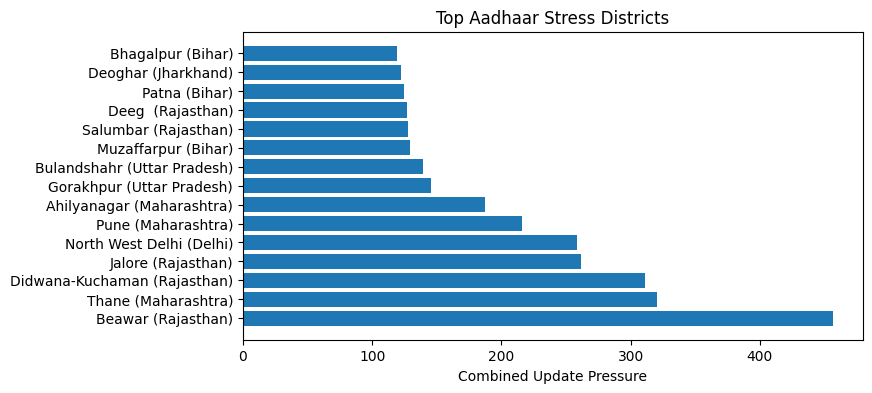

In [ ]:
district_stress = (
    df
    .groupby(['state', 'district'], as_index=False)
    .agg({
        'demo_update_ratio': 'mean',
        'bio_update_ratio': 'mean'
    })
)

district_stress['combined_stress'] = (
    district_stress['demo_update_ratio'] +
    district_stress['bio_update_ratio']
)

top_districts = district_stress.sort_values(
    'combined_stress', ascending=False
).head(15)

plt.barh(
    top_districts['district'] + ' (' + top_districts['state'] + ')',
    top_districts['combined_stress']
)
plt.title('Top Aadhaar Stress Districts')
plt.xlabel('Combined Update Pressure')
plt.show()

## Visual 4: Age-Group Contribution to Aadhaar Update Pressure

This visual compares the relative contribution of different age groups to demographic and biometric updates, reinforcing the idea that Aadhaar identity stability evolves across life stages.

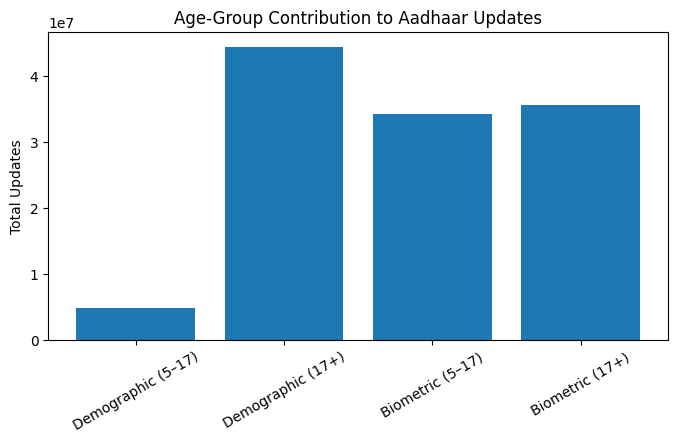

In [ ]:
demo_df = pd.read_csv('demographic_monthly.csv')
bio_df = pd.read_csv('biometric_monthly.csv')

age_pressure = {
    'Demographic (5–17)': demo_df['demo_age_5_17'].sum(),
    'Demographic (17+)': demo_df['demo_age_17_'].sum(),
    'Biometric (5–17)': bio_df['bio_age_5_17'].sum(),
    'Biometric (17+)': bio_df['bio_age_17_'].sum()
}

plt.bar(age_pressure.keys(), age_pressure.values())
plt.title('Age-Group Contribution to Aadhaar Updates')
plt.ylabel('Total Updates')
plt.xticks(rotation=30)
plt.show()

## Recreating Anomaly Score

In [ ]:
# Scale features prior to model training
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
# Train Isolation Forest model for anomaly ranking
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.10,
    random_state=42
)

iso_forest.fit(features_scaled)

IsolationForest(contamination=0.1, n_estimators=200, random_state=42)

In [ ]:
# Generate anomaly scores from trained model
df['anomaly_score'] = -iso_forest.score_samples(features_scaled)

## Recreating identity_stress_flag

In [ ]:
# Define percentile-based thresholds for high update pressure
demo_warning_threshold = df['demo_update_ratio'].quantile(0.90)
bio_warning_threshold = df['bio_update_ratio'].quantile(0.90)

In [ ]:
# Create binary warning flags based on update pressure thresholds
df['demo_update_warning'] = df['demo_update_ratio'] > demo_warning_threshold
df['bio_update_warning'] = df['bio_update_ratio'] > bio_warning_threshold

In [ ]:
# Create a composite identity stress indicator
df['identity_stress_flag'] = (
    df['demo_update_warning'] |
    df['bio_update_warning']
)

In [ ]:
# Inspect distribution of stress flags for sanity check
df['identity_stress_flag'].value_counts(normalize=True)

,proportion
identity_stress_flag,
False,0.839392
True,0.160608


In [ ]:
# Validate alignment between rule-based indicators and ML scores
df[['identity_stress_flag', 'anomaly_score']].corr()

,identity_stress_flag,anomaly_score
identity_stress_flag,1.000000,-0.012215
anomaly_score,-0.012215,1.000000


## Visual 5: Alignment Between Rule-Based Indicators and ML Anomaly Scores

This scatter plot demonstrates that ML-based anomaly ranking reinforces rule-based stress indicators while adding prioritisation nuance, rather than replacing explainable logic.

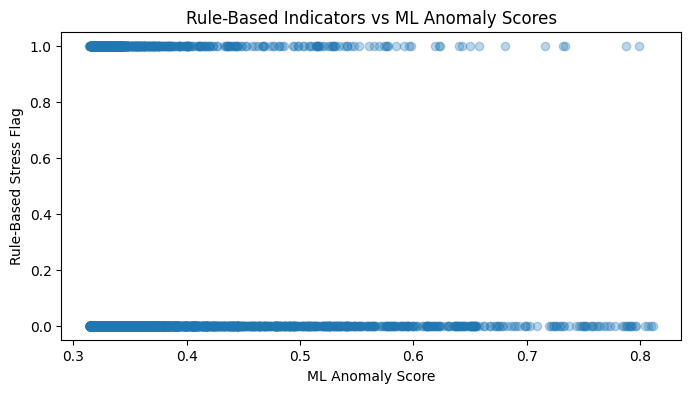

In [ ]:
plt.scatter(
    df['anomaly_score'],
    df['identity_stress_flag'].astype(int),
    alpha=0.3
)
plt.xlabel('ML Anomaly Score')
plt.ylabel('Rule-Based Stress Flag')
plt.title('Rule-Based Indicators vs ML Anomaly Scores')
plt.show()

## Recreating anomaly_rank

In [ ]:
df['anomaly_rank'] = df['anomaly_score'].rank(
    ascending=False,
    method='dense'
)

In [ ]:
df[['anomaly_score', 'anomaly_rank']].head()

,anomaly_score,anomaly_rank
0,0.342664,1756.0
1,0.342664,1756.0
2,0.342664,1756.0
3,0.342664,1756.0
4,0.322193,3424.0


## Visual 6: Aadhaar Early-Warning Dashboard Snapshot

This table represents the final analytical output of the project.
It combines update ratios, rule-based stress indicators, and ML-based anomaly ranking into a single view that enables UIDAI officials to prioritise districts for early intervention.

In [ ]:
dashboard_view = df[
    [
        'month',
        'state',
        'district',
        'demo_update_ratio',
        'bio_update_ratio',
        'identity_stress_flag',
        'anomaly_rank'
    ]
].sort_values('anomaly_rank').head(15)

dashboard_view

,month,state,district,demo_update_ratio,bio_update_ratio,identity_stress_flag,anomaly_rank
2781,2025-10-01,Punjab,Sangrur,12.493261,15.053908,False,1.0
1108,2025-09-01,Andhra Pradesh,Karimnagar,7.694545,11.410909,False,2.0
1109,2025-09-01,Andhra Pradesh,Khammam,11.322440,10.220044,False,3.0
2782,2025-10-01,Punjab,Shaheed Bhagat Singh Nagar,6.221477,11.751678,False,4.0
727,2025-06-01,Uttar Pradesh,Meerut,0.000000,69.214008,True,5.0
4445,2025-12-01,Karnataka,Bengaluru,13.472480,10.321526,False,6.0
754,2025-07-01,Arunachal Pradesh,Longding,0.000000,0.842893,False,7.0
726,2025-06-01,Uttar Pradesh,Mathura,2.632109,8.532757,False,8.0
4444,2025-12-01,Karnataka,Bellary,7.609183,9.321389,False,9.0
753,2025-07-01,Andhra Pradesh,Spsr Nellore,0.000000,0.000000,False,10.0
